# Experiments with real data (Students Performance)

https://archive.ics.uci.edu/dataset/320/student+performance


## Requirements

In [32]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'uci_students_performance_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_students_performance import get_config as get_config_exp_1_students_performance
from config_experiment_3_students_performance import get_config as get_config_exp_3_students_performance
from config_experiment_4_students_performance import get_config as get_config_exp_4_students_performance

## Data exploration


### Conceptual description

| Variable   | Descripción                                                                 | Tipo                  | Justificación                                                                                      | Valores únicos |
|------------|-----------------------------------------------------------------------------|-----------------------|---------------------------------------------------------------------------------------------------|----------------|
| failures   | Número de asignaturas reprobadas previamente.                               | Numérica (entera)     | Refleja historial académico previo; alto valor suele asociarse a menor rendimiento futuro.         | 0, 1, 2, 3    |
| absences   | Número de ausencias a clase.                                                | Numérica (entera)     | La asistencia está directamente ligada al aprendizaje y a las calificaciones finales.              | 0 – 32        |
| studytime  | Tiempo de estudio semanal (categorías: 1–4).  weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)	                              | Categórica ordinal    | Mide hábitos de estudio; más tiempo suele correlacionar con mejor rendimiento.                     | 1, 2, 3, 4    |
| schoolsup  | Apoyo educativo extra proporcionado por el colegio.                         | Binaria               | Representa recursos de refuerzo académico institucional.                                           | yes, no       |
| famsup     | Apoyo familiar en los estudios.                                             | Binaria               | El respaldo familiar influye en motivación y continuidad escolar.                                 | yes, no       |
| Medu       | Nivel educativo de la madre (0–4).                                          | Categórica ordinal    | La educación parental es un fuerte predictor del rendimiento académico de los hijos.              | 0, 1, 2, 3, 4|
| Fedu       | Nivel educativo del padre (0–4).                                            | Categórica ordinal    | Similar a `Medu`, añade contexto sociofamiliar relevante.                                          | 0, 1, 2, 3, 4|
| famrel     | Calidad de las relaciones familiares (1–5).                                 | Categórica ordinal    | Un entorno familiar estable favorece la concentración y el rendimiento escolar.                   | 1, 2, 3, 4, 5|
| goout      | Frecuencia de salidas con amigos (1–5).                                     | Categórica ordinal    | Exceso de ocio social puede competir con tiempo de estudio y afectar negativamente al rendimiento.| 1, 2, 3, 4, 5|
| Walc       | Consumo de alcohol en fines de semana (1–5).                                | Categórica ordinal    | Asociado a distracciones, menor rendimiento y problemas de salud que repercuten en los estudios.  | 1, 2, 3, 4, 5|
| health     | Estado de salud autoinformado (1–5).                                        | Categórica ordinal    | La salud condiciona la asistencia, la concentración y el rendimiento académico.                   | 1, 2, 3, 4, 5|
| G3         | Nota final del curso (0–20).                                                | Numérica (entera) (categorica ordinal, tras procesado)    | Variable objetivo a predecir, indicador del rendimiento académico global.                         | 0 – 20   ( ["suspenso", "suficiente", "bien", "notable", "sobresaliente"] tras transformarla a la escala 0 - 10 y categorizarla)    |


### Data reading

In [33]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [34]:
n_clusters

4

In [35]:
X.head()

absences,age,G3,schoolsup,famsup,sex,famsize,Pstatus,activities,higher,internet,failures,Medu,Fedu,famrel,goout,Walc,health,freetime,Mjob,Fjob
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
4,18,11,1,0,0,0,0,0,1,0,0,4,4,3,3,0,2,2,0,4
2,17,11,0,1,0,0,1,0,1,1,0,1,1,4,2,0,2,2,0,2
6,15,12,1,0,0,1,1,0,1,1,0,1,1,3,1,2,2,2,0,2
0,15,14,0,1,0,0,1,1,1,1,0,4,2,2,1,0,4,1,1,3
0,16,13,0,1,0,0,1,0,1,0,0,3,3,3,1,1,4,2,2,2


In [36]:
y.head(5)

studytime
i64
1
1
1
2
1


In [37]:
X.shape

(649, 21)

In [38]:
y.shape

(649,)

In [39]:
print(p1, p2, p3)

3 8 10


In [40]:
encoding

{'schoolsup': {'no': 0, 'yes': 1},
 'famsup': {'no': 0, 'yes': 1},
 'sex': {'F': 0, 'M': 1},
 'famsize': {'GT3': 0, 'LE3': 1},
 'Pstatus': {'A': 0, 'T': 1},
 'activities': {'no': 0, 'yes': 1},
 'higher': {'no': 0, 'yes': 1},
 'internet': {'no': 0, 'yes': 1},
 'failures': {0: 0, 1: 1, 2: 2, 3: 3},
 'Medu': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
 'Fedu': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
 'famrel': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
 'goout': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
 'Walc': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
 'health': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
 'freetime': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
 'Mjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Fjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'studytime': {1: 0, 2: 1, 3: 2, 4: 3}}

In [41]:
quant_predictors

['absences', 'age', 'G3']

In [42]:
binary_predictors

['schoolsup',
 'famsup',
 'sex',
 'famsize',
 'Pstatus',
 'activities',
 'higher',
 'internet']

In [43]:
multiclass_predictors

['failures',
 'Medu',
 'Fedu',
 'famrel',
 'goout',
 'Walc',
 'health',
 'freetime',
 'Mjob',
 'Fjob']

### Data description

In [44]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [45]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
absences,24,0.0,3.659476,4.640759,0,0.0,0.0,2.0,6.0,10.0,32,8.727404,2.01602,0.032357
age,8,0.0,16.744222,1.218138,15,15.0,16.0,17.0,18.0,18.0,22,3.061728,0.415831,0.001541
G3,17,0.0,11.906009,3.230656,0,9.0,10.0,12.0,14.0,16.0,19,5.682123,-0.910798,0.024653


In [46]:
cat_summary

,n_unique,perc_nan,mode
schoolsup,2,0.0,0
famsup,2,0.0,1
sex,2,0.0,0
famsize,2,0.0,0
Pstatus,2,0.0,1
activities,2,0.0,0
higher,2,0.0,1
internet,2,0.0,1
failures,4,0.0,0
Medu,5,0.0,2


In [47]:
quant_summary, cat_summary = summary(df=pl.DataFrame(y), cat_col_names = [y.name])

In [48]:
cat_summary

,n_unique,perc_nan,mode
studytime,4,0.0,1


In [49]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.3266563944530046, 1: 0.4699537750385208, 2: 0.14946070878274267, 3: 0.053929121725731895}


In [50]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""absences""",-9.0,15.0,21,628,0.032357,0.967643
"""age""",13.0,21.0,1,648,0.001541,0.998459
"""G3""",4.0,20.0,16,633,0.024653,0.975347


In [51]:
outliers_df['prop_outliers'].mean()

0.019517205957883924

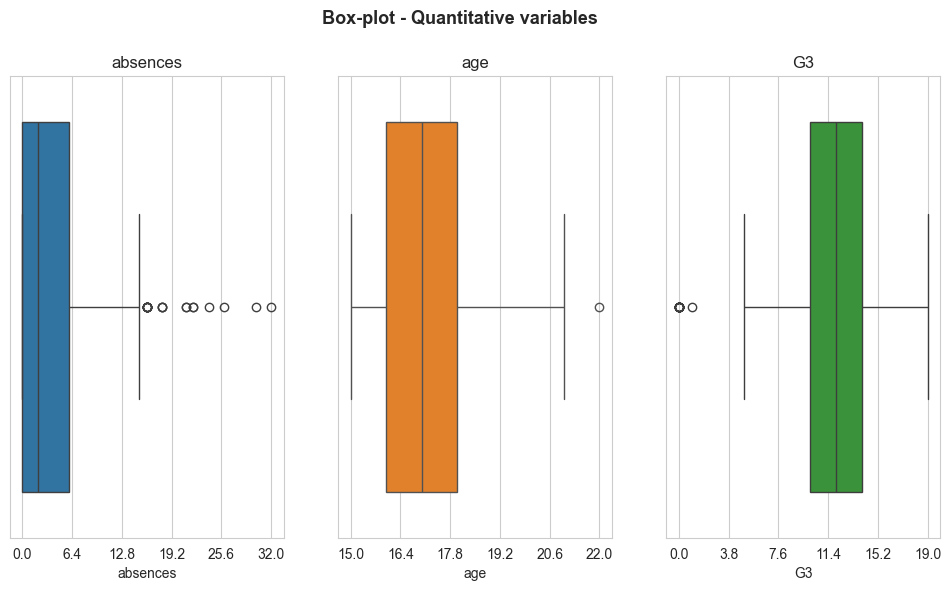

In [52]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(12,6), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.2, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

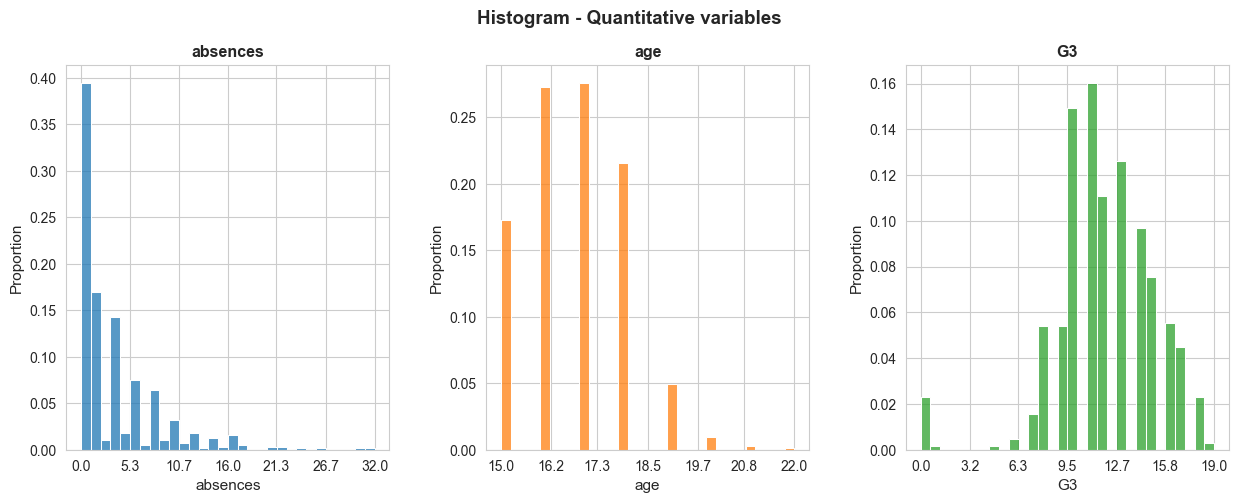

In [54]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,5), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.85, wspace=0.3, n_round_xticks=1)

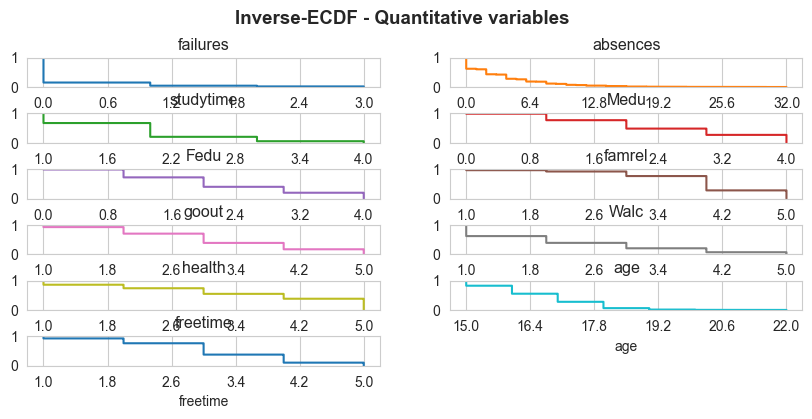

In [81]:
ecdfplot_matrix(df=X, 
                n_cols=2, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(10,4), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

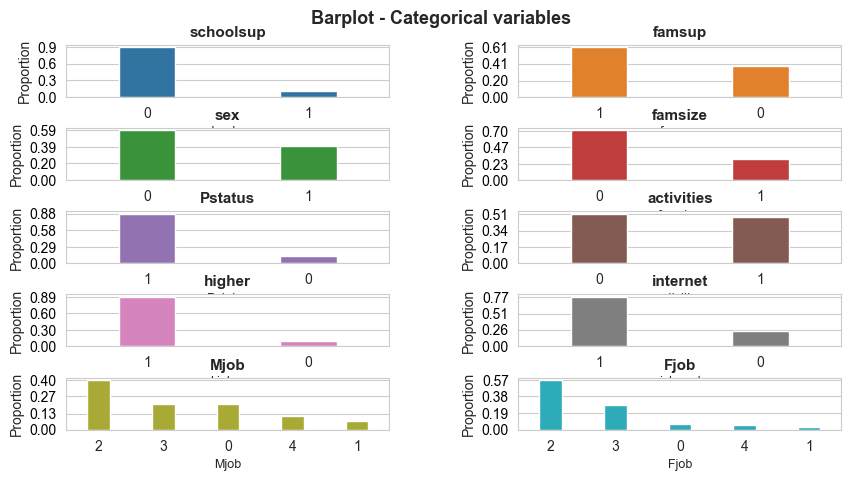

In [82]:
# Barplot
barplot_matrix(df=X, 
               n_cols=2, 
               title='Barplot - Categorical variables', 
               figsize=(10,5), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.6, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [55]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,absences,age,G3
absences,1.000000,0.149998,-0.091379
age,0.149998,1.000000,-0.106505
G3,-0.091379,-0.106505,1.000000


In [56]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.0
Proportion of pair-wise correlations in [0.30, 0.60]:  0.0
Proportion of pair-wise correlation < 0.30 (in abs. value):  1.0


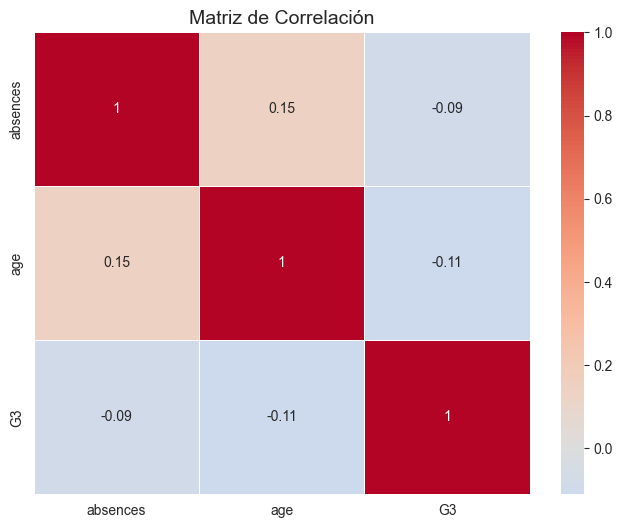

In [57]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()



## Experiment 1


In [58]:
run_experiment_1 = True

In [59]:
if run_experiment_1: 
        
    n_realizations = 10
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'students_performance')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251001_172810'

    config_exp_1 = get_config_exp_1_students_performance()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [60]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score #accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_students_performance_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 25 realizations: 41 mins

chunks:   0%|          | 0/2 [00:00<?, ?chunks/s]

random_state_chunk: [857, 4385, 1428, 6672, 4367]
random_state: 857
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 4385
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 1428
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y

chunks:  50%|█████     | 1/2 [00:19<00:19, 19.24s/chunks]

len y_pred: 4
random_state_chunk: [1764, 625, 6211, 8785, 9213]
random_state: 1764
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 625
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 6211
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_s

chunks: 100%|██████████| 2/2 [00:39<00:00, 19.52s/chunks]

len y_pred: 4


In [61]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'students_performance')
    file_id = '20251001_172810'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_students_performance_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_students_performance_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [62]:
# Open merged/joined results 

file_id = '20251001_172810'
results_filename = f'results_exp_1_students_performance_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'students_performance')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [63]:
experiment_1_config = get_config_exp_1_students_performance()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [64]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

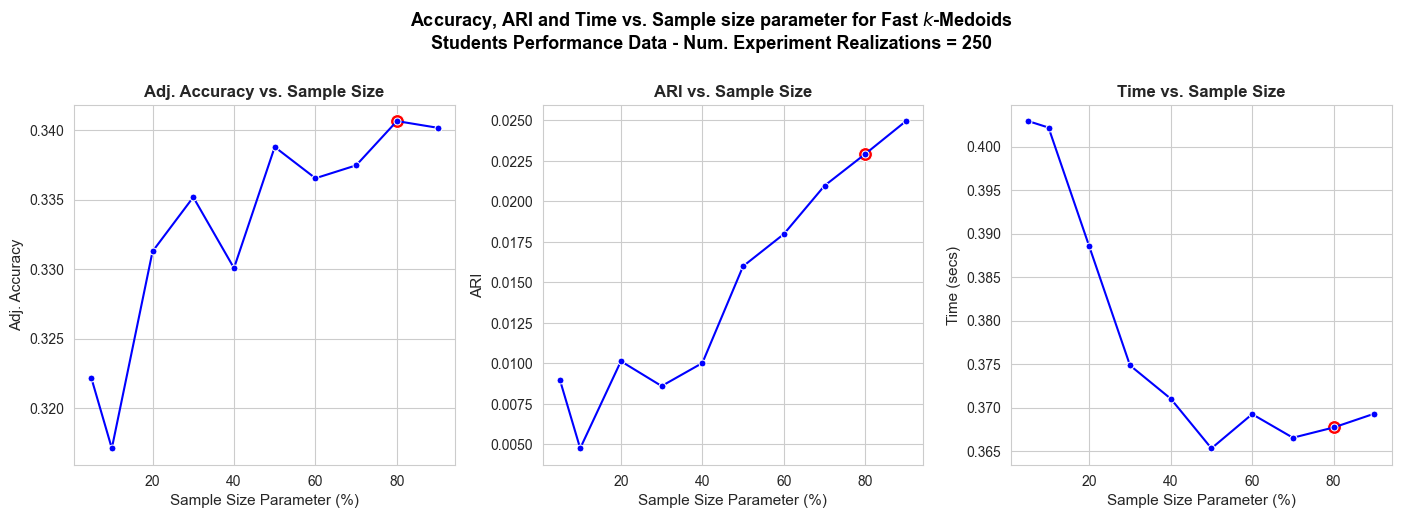

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample size parameter for Fast $k$-Medoids\nStudents Performance Data - Num. Experiment Realizations = 250', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_students_performance_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [66]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.05,0.402944,0.322131,0.009000
0.10,0.402198,0.317099,0.004758
0.20,0.388527,0.331267,0.010133
0.30,0.374854,0.335168,0.008601
0.40,0.371025,0.330066,0.010022
0.50,0.365313,0.338779,0.015992
0.60,0.369248,0.336529,0.017974
0.70,0.366535,0.337457,0.020959
0.80,0.367714,0.340641,0.022919


In [67]:
print(best_frac_sample_size)

0.8



## Experiment 3


In [68]:
run_experiment_3 = True

In [69]:
if run_experiment_3: 

    n_realizations = 10
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'students_performance')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251002_223652'

    config_exp_3 = get_config_exp_3_students_performance()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [70]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=balanced_accuracy_score #accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_students_performance_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 25 realizations: 87 mins

chunks:   0%|          | 0/4 [00:00<?, ?chunks/s]

random_state_chunk: [857, 4385, 1428]
random_state: 857
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


random_state: 4385
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


random_state: 1428
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.77it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


frac_sample_size: 0.8


chunks:  25%|██▌       | 1/4 [03:52<11:38, 232.93s/chunks]

random_state_chunk: [6672, 4367, 1764]
random_state: 6672
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


random_state: 4367
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


random_state: 1764
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


frac_sample_size: 0.8


chunks:  50%|█████     | 2/4 [06:50<06:41, 200.66s/chunks]

random_state_chunk: [625, 6211, 8785]
random_state: 625
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


random_state: 6211
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.71it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


random_state: 8785
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


frac_sample_size: 0.8


chunks:  75%|███████▌  | 3/4 [09:40<03:06, 186.51s/chunks]

random_state_chunk: [9213]
random_state: 9213
n_splits: 5
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


n_splits: 7
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


n_splits: 10
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


n_splits: 15
frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]


frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


frac_sample_size: 0.8


chunks: 100%|██████████| 4/4 [10:41<00:00, 160.35s/chunks]


In [71]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20251002_223652'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_students_performance_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_students_performance_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [72]:
# Open merged/joined results 

file_id = '20251002_223652'
results_filename = f'results_exp_3_students_performance_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'students_performance')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [73]:
config_exp_3 = get_config_exp_3_students_performance()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

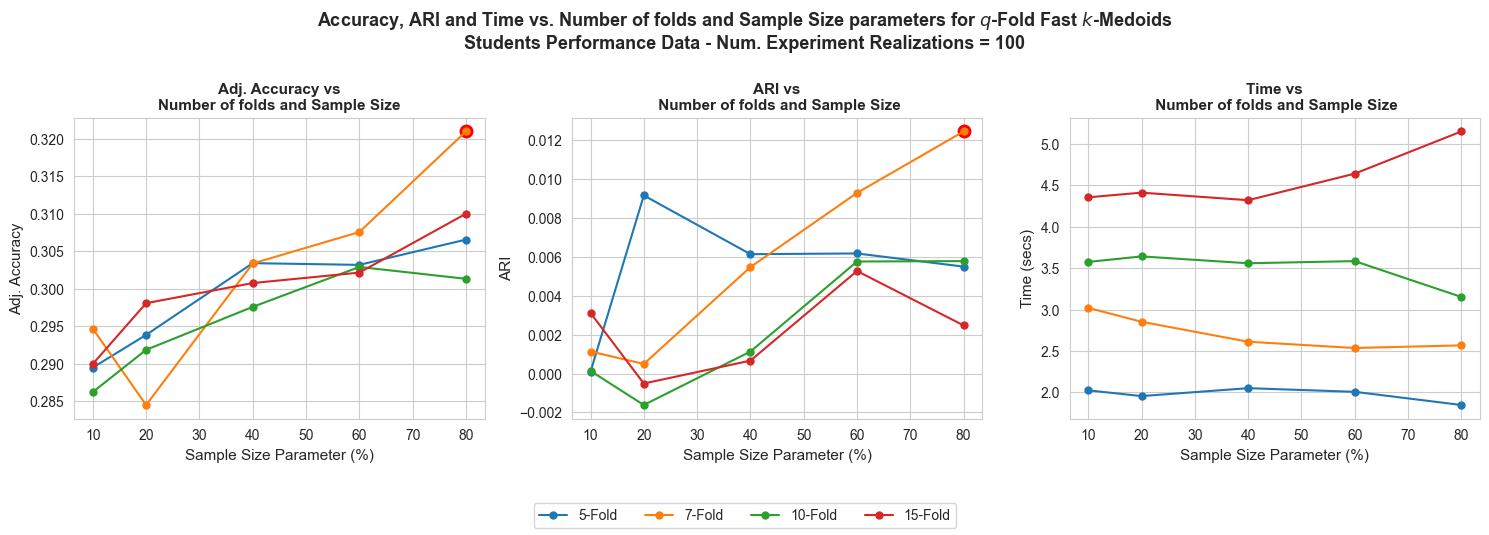

In [74]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of folds and Sample Size parameters for $q$-Fold Fast $k$-Medoids\nStudents Performance Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_students_performance_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [16]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.1,0.352848,0.001449,6.847117
1,5,0.2,0.357309,0.001830,7.378647
2,5,0.4,0.355284,0.001594,7.496226
3,5,0.6,0.354300,-0.001336,7.401506
4,5,0.8,0.351381,-0.001874,7.546617
5,7,0.1,0.359966,0.002740,10.264686
6,7,0.2,0.356992,0.004750,10.230990
7,7,0.4,0.359825,0.001082,9.528811
8,7,0.6,0.358935,0.000863,8.756261
9,7,0.8,0.360047,0.001176,8.992418


In [75]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 1.079 
 best_n_splits 7.0 
 best_frac_sample_size 0.8



## Experiment 4

In [77]:
config_exp_4 = get_config_exp_4_students_performance()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis', 'euclidean', 'canberra', 'minkowski']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 10
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            label_model_name = f'{d1}_{r}-{d2}-{d3}'
        else:
            r = None
            label_model_name = f'{d1}-{d2}-{d3}'
            
        models[random_state][f'FastKmedoidsGGower-{label_model_name}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{label_model_name}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [78]:
run_experiment_4 = True

In [79]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'students_performance')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = "20251002_223652"

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [80]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=balanced_accuracy_score #accuracy_score
            )

        # Save results
        results_filename = f'results_exp_4_students_performance_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 25 realizations: 14 mins

chunks:   0%|          | 0/4 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [857, 4385, 1428]
random_state: 857
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.30it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.17it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


len y_pred: 4
random_state: 4385
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.28it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  7.39it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:01<00:00,  7.79it/s]


len y_pred: 4
random_state: 1428
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.05it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  25%|██▌       | 1/4 [02:14<06:43, 134.59s/chunks]

len y_pred: 4
chunk_id 1
random_state_chunk: [6672, 4367, 1764]
random_state: 6672
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  6.26it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


len y_pred: 4
random_state: 4367
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


len y_pred: 4
random_state: 1764
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.42it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  50%|█████     | 2/4 [05:21<05:30, 165.40s/chunks]

len y_pred: 4
chunk_id 2
random_state_chunk: [625, 6211, 8785]
random_state: 625
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


len y_pred: 4
random_state: 6211
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


len y_pred: 4
random_state: 8785
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  3.00it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  75%|███████▌  | 3/4 [08:51<03:05, 185.90s/chunks]

len y_pred: 4
chunk_id 3
random_state_chunk: [9213]
random_state: 9213
KMeans
len y_pred: 4
CLARA
len y_pred: 4
Diana
len y_pred: 4
LDAKmeans
len y_pred: 4
SubKmeans
len y_pred: 4
GaussianMixture
len y_pred: 4
AgglomerativeClustering
len y_pred: 4
SpectralBiclustering
len y_pred: 4
SpectralCoclustering
len y_pred: 4
Birch
len y_pred: 4
BisectingKMeans
len y_pred: 4
MiniBatchKMeans
len y_pred: 4
KMedoids-euclidean
len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


len y_pred: 4
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


len y_pred: 4
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


len y_pred: 4
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


len y_pred: 4
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 4
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks: 100%|██████████| 4/4 [10:01<00:00, 150.40s/chunks]

len y_pred: 4


In [81]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'students_performance')
    file_id = '20251002_223652'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_students_performance_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_students_performance_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [82]:
# Open merged/joined results 

file_id = '20251002_223652'
results_filename = f'results_exp_4_students_performance_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'students_performance')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [83]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [84]:
not_feasible_methods = [] 

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

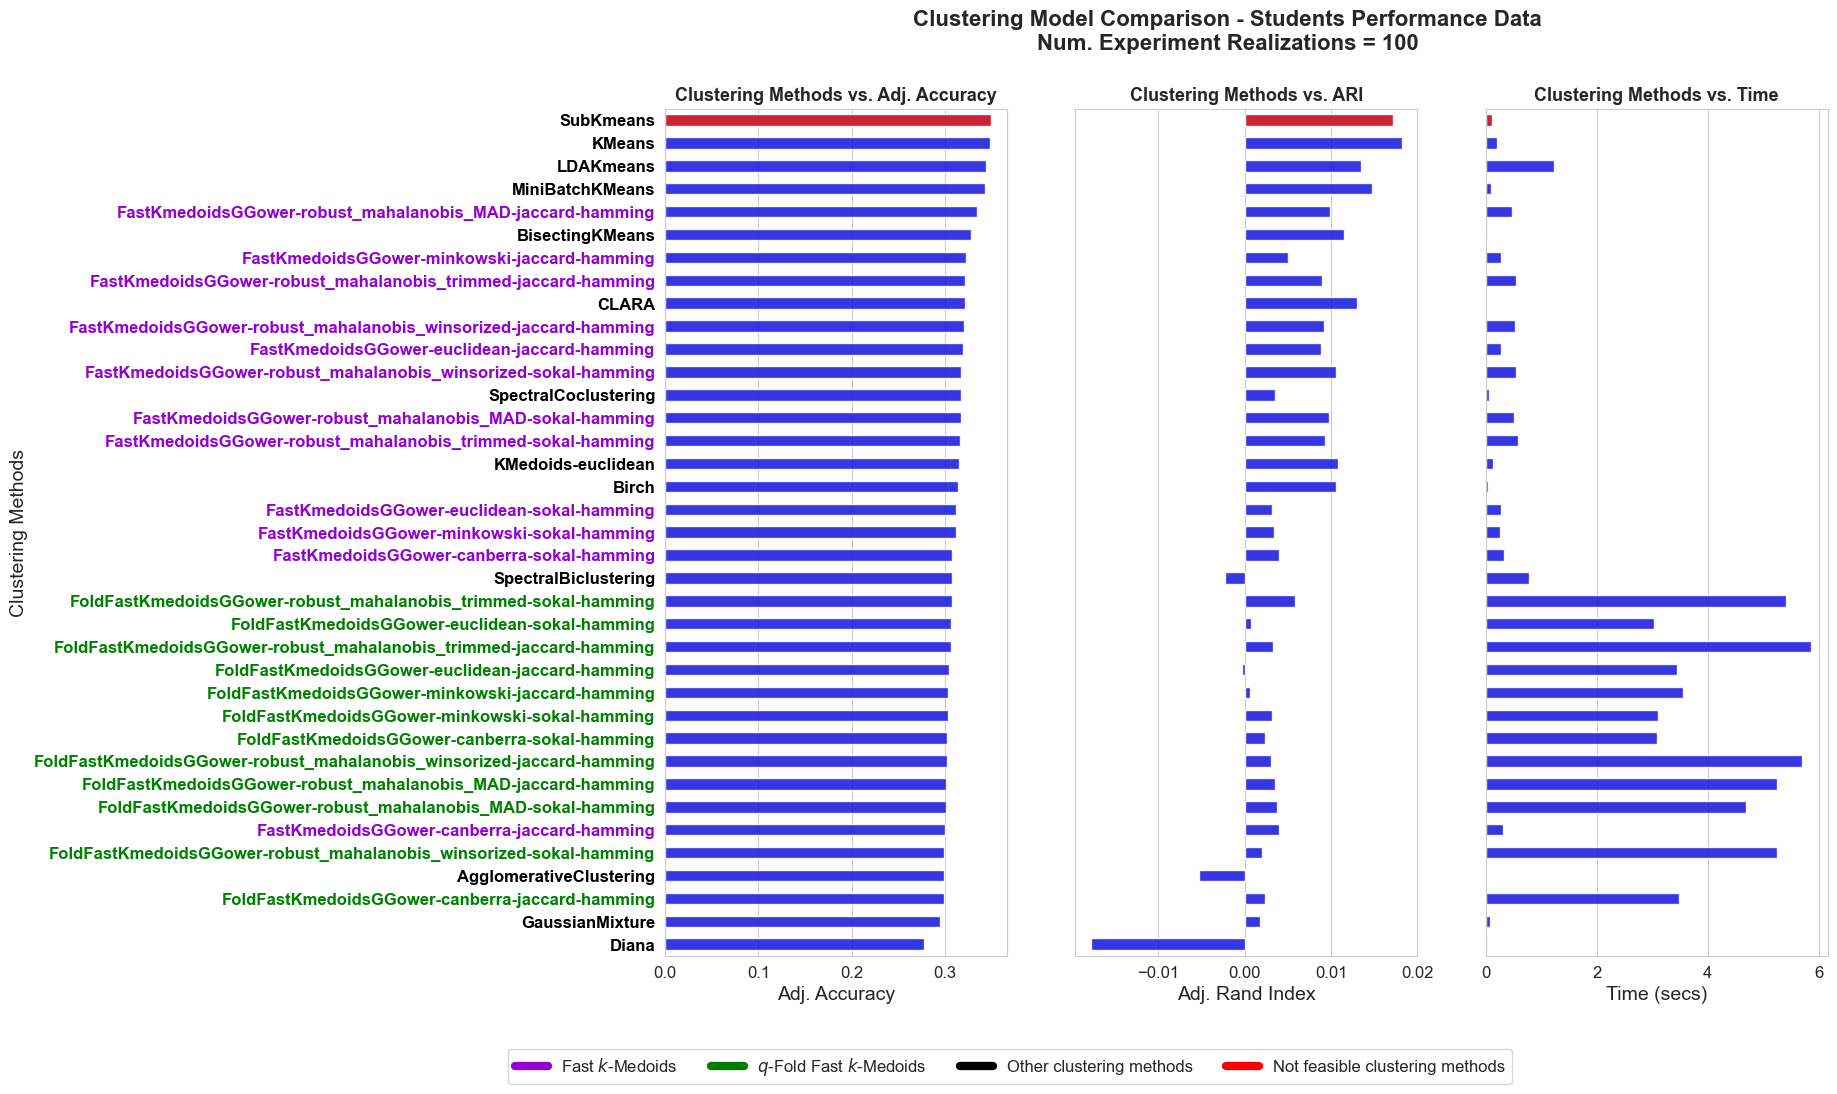

In [85]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - Students Performance Data\nNum. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_students_performance_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [90]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [97]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
SubKmeans,0.104085,0.349438,0.017145
KMeans,0.195757,0.348995,0.018204
LDAKmeans,1.229169,0.344623,0.013448
MiniBatchKMeans,0.103162,0.343055,0.014795
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,0.469806,0.334804,0.009835
BisectingKMeans,0.016293,0.328346,0.011559
FastKmedoidsGGower-minkowski-jaccard-hamming,0.283117,0.322395,0.004973
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,0.551297,0.322131,0.009000
CLARA,0.011206,0.321858,0.013054


In [92]:
results.keys()

dict_keys([857, 4385, 1428, 6672, 4367, 1764, 625, 6211, 8785, 9213])

In [ ]:
random_state_mds = 857

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.6, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [94]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'KMedoids-euclidean']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

In [96]:
accuracy_dict

{'Best Fast k-medoids': 0.37480988694915784,
 'Best q-Fold Fast k-medoids': 0.28491104711309684,
 'SubKmeans': 0.34798865778944765,
 'KMeans': 0.3212490496340436,
 'KMedoids-euclidean': 0.31507468885622175}

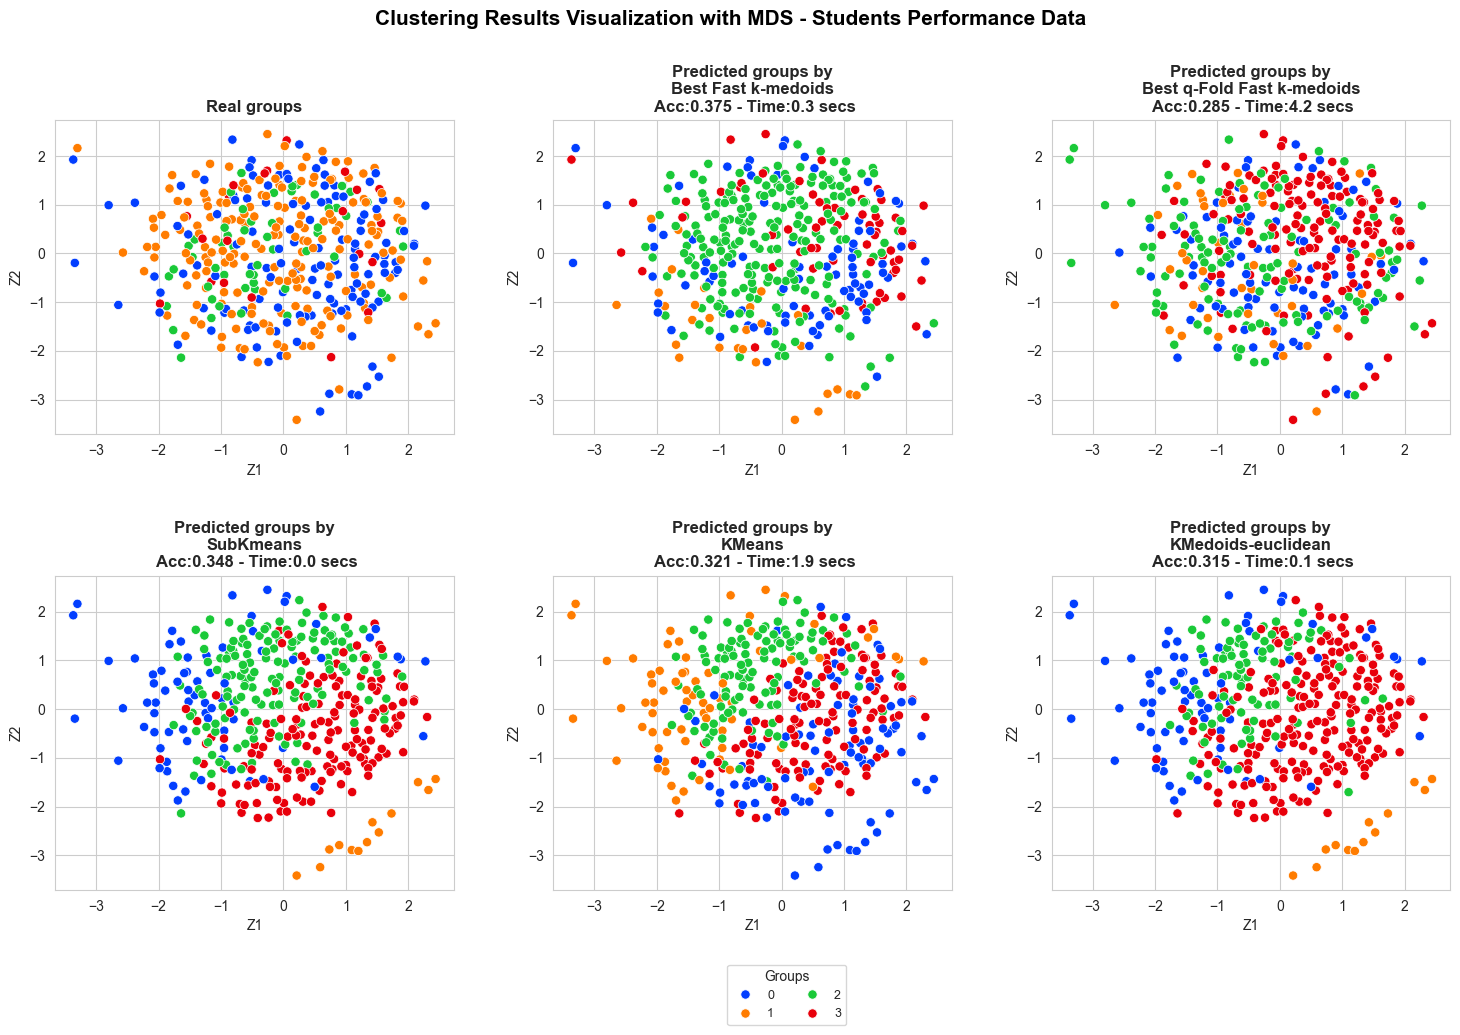

In [95]:
plot_filename = f'mds_plot_exp_4_students_performance_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'students_performance')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Students Performance Data", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=15, title_weight='bold', 
                                     subtitles_size=12,
                                     points_size=45, title_height=0.99, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)